In [1]:
# Binary Classifier implementation (model architecture, training, testing, etc.) derived from
#     https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89

In [2]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tree import Tree
import numpy as np
import pickle
import random
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from stanfordcorenlp import StanfordCoreNLP
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
MAX_PHRASE_LEN = 6
VECTOR_SIZE = 200
WINDOW_SIZE = 5
NUM_LAYERS = 5

MIN_FREQUENCY = 5

SHOULD_EXTRACT_NOUN_PHRASES = False
SHOULD_GENERATE_UNDERSCORED_CORPUS = False
SHOULD_TRAIN_WORD2VEC_MODEL = False

EPOCHS = 400
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [4]:
with open('data/arxiv_abstracts_10000.txt', 'r') as f:
    arxiv_abstracts = f.read().split('\n')[:-1]
    arxiv_abstracts_raw = '\n'.join(arxiv_abstracts)
    f.close()
print(f'Loaded {len(arxiv_abstracts)} arxiv abstracts.')

Loaded 10000 arxiv abstracts.


In [5]:
negative_samples = pickle.load(open('data/negative_samples.pkl', 'rb'))
print(f'Loaded {len(negative_samples)} negative samples.')

Loaded 1900 negative samples.


In [6]:
positive_samples = pickle.load(open('data/positive_samples.pkl', 'rb'))
print(f'Loaded {len(positive_samples)} positive samples.')

Loaded 1900 positive samples.


In [7]:
def extract_phrase(tree_str, label):
    phrases = []
    trees = Tree.fromstring(tree_str)
    for tree in trees:
        for subtree in tree.subtrees():
            if subtree.label() == label:
                t = subtree
                t = ' '.join(t.leaves())
                phrases.append(t)
    return phrases

In [8]:
if SHOULD_EXTRACT_NOUN_PHRASES:
    nlp = StanfordCoreNLP('data/stanford-corenlp-4.1.0')
    noun_phrases = []
    for i, abstract in enumerate(arxiv_abstracts):
        if (i + 1) % 10 == 0:
            print(f'Extracting noun phrases from abstract {i + 1} of {len(arxiv_abstracts)}')
            pickle.dump(noun_phrases, open('data/noun_phrases.pkl', 'wb'))
        try:
            tree_str = nlp.parse(abstract)
            noun_phrases.extend(extract_phrase(tree_str, 'NP'))
        except Exception:
            pass
    noun_phrases = [np for np in list(set(noun_phrases)) if len(np.split()) <= MAX_PHRASE_LEN]
    pickle.dump(noun_phrases, open('data/noun_phrases.pkl', 'wb'))
noun_phrases = pickle.load(open('data/noun_phrases.pkl', 'rb'))
noun_phrases = [np for np in list(set(noun_phrases)) if len(np.split()) <= MAX_PHRASE_LEN]

In [9]:
def find_phrase_in_corpus(corpus, phrase):
    s_idx = corpus.find(phrase)
    e_idx = s_idx + len(phrase)
    if s_idx != -1 and \
       (s_idx == 0 or corpus[s_idx - 1] in (string.punctuation + ' ')) and \
       (e_idx == len(corpus) or corpus[e_idx] in (string.punctuation + ' ')):
        return (s_idx, e_idx)
    return (-1, -1)

In [10]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    corpus = arxiv_abstracts_raw[:]

In [11]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    for i, positive_sample in enumerate(positive_samples):
        if (i + 1) % 100 == 0:
            print(f'Replacing positive_sample {i + 1} of {len(positive_samples)}')
        found_indices = set()
        while find_phrase_in_corpus(corpus, positive_sample) != (-1, -1) and find_phrase_in_corpus(corpus, positive_sample)[0] not in found_indices:
            s_idx, e_idx = find_phrase_in_corpus(corpus, positive_sample)
            found_indices.add(s_idx)
            corpus = corpus[:s_idx] + positive_sample.replace(' ', '_') + corpus[e_idx:]

In [12]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    for i, negative_sample in enumerate(negative_samples):
        if (i + 1) % 100 == 0:
            print(f'Replacing negative_sample {i + 1} of {len(negative_samples)}')
        found_indices = set()
        while find_phrase_in_corpus(corpus, negative_sample) != (-1, -1) and find_phrase_in_corpus(corpus, negative_sample)[0] not in found_indices:
            s_idx, e_idx = find_phrase_in_corpus(corpus, negative_sample)
            found_indices.add(s_idx)
            corpus = corpus[:s_idx] + negative_sample.replace(' ', '_') + corpus[e_idx:]

In [13]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    for i, noun_phrase in enumerate(noun_phrases):
        if (i + 1) % 100 == 0:
            print(f'Replacing noun_phrase {i + 1} of {len(noun_phrases)}')
        found_indices = set()
        while find_phrase_in_corpus(corpus, noun_phrase) != (-1, -1) and find_phrase_in_corpus(corpus, noun_phrase)[0] not in found_indices:
            s_idx, e_idx = find_phrase_in_corpus(corpus, noun_phrase)
            found_indices.add(s_idx)
            corpus = corpus[:s_idx] + noun_phrase.replace(' ', '_') + corpus[e_idx:]

In [14]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    pickle.dump(corpus, open('data/underscored_corpus.pkl', 'wb'))

In [15]:
underscored_corpus = pickle.load(open('data/underscored_corpus.pkl', 'rb'))

In [16]:
if SHOULD_TRAIN_WORD2VEC_MODEL:
    underscored_corpus_data = []
    for i in sent_tokenize(underscored_corpus):
        temp = []
        for j in word_tokenize(i):
            temp.append(j.lower())
        underscored_corpus_data.append(temp)

In [17]:
if SHOULD_TRAIN_WORD2VEC_MODEL:
    word2vec_model = Word2Vec(underscored_corpus_data, min_count=1, window=WINDOW_SIZE, size=VECTOR_SIZE)
    word2vec_model.save(f'data/word2vec_model_vs_{VECTOR_SIZE}_ws_{WINDOW_SIZE}')

In [18]:
word2vec_model = Word2Vec.load(f'data/word2vec_model_vs_{VECTOR_SIZE}_ws_{WINDOW_SIZE}')

In [19]:
tokens = [token for token in list(word2vec_model.wv.vocab.keys())]
embeddings = {token: word2vec_model.wv[token] for token in tokens}

In [20]:
positive_samples = [ps for ps in positive_samples if ps.replace(' ', '_') in embeddings and word2vec_model.wv.vocab[ps.replace(' ', '_')].count >= MIN_FREQUENCY]
negative_samples = [ns for ns in negative_samples if ns.replace(' ', '_') in embeddings and word2vec_model.wv.vocab[ns.replace(' ', '_')].count >= MIN_FREQUENCY]
noun_phrases = [np for np in noun_phrases if np.replace(' ', '_') in embeddings and word2vec_model.wv.vocab[np.replace(' ', '_')].count >= MIN_FREQUENCY]

In [21]:
X = []
y = []
for phrase in positive_samples:
    X.append(embeddings[phrase.replace(' ', '_')])
    y.append(1)
for phrase in negative_samples:
    X.append(embeddings[phrase.replace(' ', '_')])
    y.append(0)

In [22]:
c = list(zip(X, y))
random.shuffle(c)
X, y = zip(*c)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()

        self.layer_1 = nn.Linear(VECTOR_SIZE, 128)
        
        self.layers = []
        for _ in range(NUM_LAYERS - 1):
            self.layers.append(nn.Linear(128, 128))
        
        self.layer_out = nn.Linear(128, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        
        for layer in self.layers:
            x = self.relu(layer(x))

        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BinaryClassifier()
model.to(device)

BinaryClassifier(
  (layer_1): Linear(in_features=200, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [26]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [27]:
class TrainDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_data = TrainDataset(torch.FloatTensor(np.array(X_train, dtype=np.float64)), 
                          torch.FloatTensor(y_train))

In [28]:
class TestDataset(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestDataset(torch.FloatTensor(np.array(X_test, dtype=np.float64)))

In [29]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [30]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [31]:
epoch_losses = []
for e in range(1, EPOCHS + 1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    epoch_losses.append(epoch_loss / len(train_loader)) 

    if e % 10 == 0:
        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 010: | Loss: 0.60216 | Acc: 67.263
Epoch 020: | Loss: 0.48714 | Acc: 78.526
Epoch 030: | Loss: 0.43054 | Acc: 80.526
Epoch 040: | Loss: 0.40129 | Acc: 82.474
Epoch 050: | Loss: 0.37765 | Acc: 83.474
Epoch 060: | Loss: 0.36348 | Acc: 84.105
Epoch 070: | Loss: 0.34564 | Acc: 84.632
Epoch 080: | Loss: 0.33062 | Acc: 85.632
Epoch 090: | Loss: 0.31747 | Acc: 86.632
Epoch 100: | Loss: 0.30831 | Acc: 86.526
Epoch 110: | Loss: 0.30238 | Acc: 86.684
Epoch 120: | Loss: 0.28695 | Acc: 87.579
Epoch 130: | Loss: 0.28267 | Acc: 87.842
Epoch 140: | Loss: 0.27542 | Acc: 88.211
Epoch 150: | Loss: 0.26665 | Acc: 88.895
Epoch 160: | Loss: 0.26011 | Acc: 89.368
Epoch 170: | Loss: 0.25470 | Acc: 89.526
Epoch 180: | Loss: 0.25059 | Acc: 89.737
Epoch 190: | Loss: 0.24512 | Acc: 89.474
Epoch 200: | Loss: 0.23993 | Acc: 90.000
Epoch 210: | Loss: 0.23303 | Acc: 90.737
Epoch 220: | Loss: 0.22932 | Acc: 90.895
Epoch 230: | Loss: 0.22604 | Acc: 91.000
Epoch 240: | Loss: 0.22139 | Acc: 91.421
Epoch 250: | Los

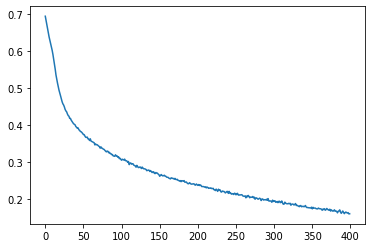

In [32]:
plt.plot(epoch_losses)

In [33]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [34]:
print(confusion_matrix(y_test, y_pred_list))
print(classification_report(y_test, y_pred_list))

[[ 82  32]
 [ 22 168]]
              precision    recall  f1-score   support

           0       0.79      0.72      0.75       114
           1       0.84      0.88      0.86       190

    accuracy                           0.82       304
   macro avg       0.81      0.80      0.81       304
weighted avg       0.82      0.82      0.82       304



In [35]:
test_samples = random.sample(noun_phrases, 1000)
X_samples = []
for sample in test_samples:
    X_samples.append(embeddings[sample.replace(' ', '_')])
sample_data = TestDataset(torch.FloatTensor(np.array(X_samples, dtype=np.float64)))
sample_loader = DataLoader(dataset=sample_data, batch_size=1)

extracted = []
not_extracted = []
model.eval()
with torch.no_grad():
    for i, X_batch in enumerate(sample_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        if y_pred_tag.cpu().numpy()[0][0] == 1:
            extracted.append(test_samples[i])
        else:
            not_extracted.append(test_samples[i])

In [36]:
extracted

['combinations',
 'kbrl',
 'imagery',
 'deep learning techniques',
 'motifs',
 'each feature',
 'then',
 'many models',
 'positions',
 'potts',
 'streaming data',
 'understanding',
 'a local optimum',
 'the log softmax',
 'she',
 'causality',
 'words',
 'the scene',
 'the precision',
 'sentiment analysis',
 'a large body',
 'metric learning',
 'the knowledge',
 'cho',
 '2012',
 'reranking',
 'video',
 'neighbors',
 'an attention mechanism',
 'cost',
 'federated',
 'capabilities',
 'new observations',
 'bangla',
 'research papers',
 'loss of accuracy',
 'computer',
 'question',
 'attentions',
 'era',
 'multiple levels',
 'their environment',
 'perception',
 'the optimization problem',
 'prediction time',
 'caption generation',
 'deep networks',
 'transparency',
 'large datasets',
 'detections',
 'rewards',
 'linear projections',
 'trends',
 'soft constraints',
 'probability',
 'school',
 'pillars',
 'neural networks based',
 'the problem of image',
 'super convergence',
 'distributed pr

In [37]:
not_extracted

['ensembles',
 'the training data',
 'the learning rate',
 'the art approaches',
 'two tasks',
 'impact',
 'better',
 'convnets',
 'most',
 'charts',
 'speech data',
 'the output',
 'art',
 'four',
 'practitioners',
 'expectation maximization',
 'there',
 'the algorithm',
 'dynamics',
 'they',
 'an open challenge',
 'short term memory',
 'technologies',
 'factorization',
 'resources',
 'these',
 'the need',
 'the effectiveness',
 'important class',
 'pu',
 'highlights',
 'generalization ability',
 'the parameters',
 'deep q',
 'decisions',
 'scenarios',
 'capturing',
 'categories',
 'unique challenges',
 'theorems',
 'the probability distribution',
 'the robustness',
 'high level tasks',
 'bayesian learning',
 'solutions',
 'latent variables',
 'dictionaries',
 'need',
 'imitation',
 'sets',
 'recurrent networks',
 'anomalies',
 'data sparsity',
 'the training process',
 'irl',
 'the accuracy',
 'dataset',
 'the core',
 'superiority',
 'the benefits',
 'structured outputs',
 'samples',

In [38]:
random.sample(extracted, 10)

['document classification',
 'clustering tasks',
 'a new perspective',
 'the vanishing',
 'respect',
 'arrays',
 'resolutions',
 'noisier',
 'both modalities',
 'game']

In [39]:
random.sample(not_extracted, 10)

['aims',
 'a challenging problem',
 'signals',
 'samples',
 'performance',
 'mislabeled',
 'accurate predictions',
 'advantages',
 'areas',
 'presence']